<a href="https://colab.research.google.com/github/lucdekeijzer/Assignment_3_Spaceship_Titanic/blob/main/Assignment_3_Spaceship_Titanic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [62]:
from google.colab import userdata
import os

os.environ["KAGGLE_KEY"] = userdata.get('KAGGLE_KEY')
os.environ["KAGGLE_USERNAME"] = userdata.get('KAGGLE_USERNAME')

In [63]:
dataset = 'spaceship-titanic'

!kaggle competitions download -c $dataset

zip_file = f"{dataset}.zip"
destination_dir = f"/content/{dataset}"

if not os.path.exists(zip_file):
    print(f"Error: {zip_file} not found.")
else:
    !unzip -q $zip_file -d $destination_dir
    !rm $zip_file

100% 299k/299k [00:00<00:00, 882kB/s]
100% 299k/299k [00:00<00:00, 880kB/s]
replace /content/spaceship-titanic/sample_submission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [74]:
import pandas as pd


train_data_df = pd.read_csv("/content/spaceship-titanic/train.csv")
test_data_df = pd.read_csv("/content/spaceship-titanic/test.csv")
print(train_data_df)



     PassengerId HomePlanet CryoSleep     Cabin    Destination   Age    VIP  \
0        0001_01     Europa     False     B/0/P    TRAPPIST-1e  39.0  False   
1        0002_01      Earth     False     F/0/S    TRAPPIST-1e  24.0  False   
2        0003_01     Europa     False     A/0/S    TRAPPIST-1e  58.0   True   
3        0003_02     Europa     False     A/0/S    TRAPPIST-1e  33.0  False   
4        0004_01      Earth     False     F/1/S    TRAPPIST-1e  16.0  False   
...          ...        ...       ...       ...            ...   ...    ...   
8688     9276_01     Europa     False    A/98/P    55 Cancri e  41.0   True   
8689     9278_01      Earth      True  G/1499/S  PSO J318.5-22  18.0  False   
8690     9279_01      Earth     False  G/1500/S    TRAPPIST-1e  26.0  False   
8691     9280_01     Europa     False   E/608/S    55 Cancri e  32.0  False   
8692     9280_02     Europa     False   E/608/S    TRAPPIST-1e  44.0  False   

      RoomService  FoodCourt  ShoppingMall     Spa 

In [65]:
train_data_df.isna().sum()

PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

In [66]:
print(len(train_data_df))
train_data_df_filled_na = train_data_df.fillna(method = "ffill")
print(len(train_data_df))

8693
8693


In [67]:
train_data_df.isna().sum()

PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

In [68]:
print(train_data_df_filled_na.dtypes)

PassengerId      object
HomePlanet       object
CryoSleep          bool
Cabin            object
Destination      object
Age             float64
VIP                bool
RoomService     float64
FoodCourt       float64
ShoppingMall    float64
Spa             float64
VRDeck          float64
Name             object
Transported        bool
dtype: object


In [69]:
len(train_data_df_filled_na)

X = train_data_df_filled_na.loc[:, train_data_df.columns != 'Transported']
y = train_data_df_filled_na['Transported']


In [70]:
# Encoding
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
X['PassengerId'] = label_encoder.fit_transform(X['PassengerId'])
X["HomePlanet"] = label_encoder.fit_transform(X["HomePlanet"])
X['Destination'] = label_encoder.fit_transform(X['Destination'])
X['Cabin'] = label_encoder.fit_transform(X['Cabin'])
X['Name'] = label_encoder.fit_transform(X['Name'])
print(X)

      PassengerId  HomePlanet  CryoSleep  Cabin  Destination   Age    VIP  \
0               0           1      False    149            2  39.0  False   
1               1           0      False   2184            2  24.0  False   
2               2           1      False      1            2  58.0   True   
3               3           1      False      1            2  33.0  False   
4               4           0      False   2186            2  16.0  False   
...           ...         ...        ...    ...          ...   ...    ...   
8688         8688           1      False    146            0  41.0   True   
8689         8689           0       True   5280            1  18.0  False   
8690         8690           0      False   5285            2  26.0  False   
8691         8691           1      False   2131            0  32.0  False   
8692         8692           1      False   2131            2  44.0  False   

      RoomService  FoodCourt  ShoppingMall     Spa  VRDeck  Name  
0       

<ipython-input-70-0c7824e23c65>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['PassengerId'] = label_encoder.fit_transform(X['PassengerId'])
<ipython-input-70-0c7824e23c65>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["HomePlanet"] = label_encoder.fit_transform(X["HomePlanet"])
<ipython-input-70-0c7824e23c65>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: 

In [71]:
print(X.dtypes)

PassengerId       int64
HomePlanet        int64
CryoSleep          bool
Cabin             int64
Destination       int64
Age             float64
VIP                bool
RoomService     float64
FoodCourt       float64
ShoppingMall    float64
Spa             float64
VRDeck          float64
Name              int64
dtype: object


In [72]:
from sklearn.model_selection import train_test_split, GridSearchCV

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.3)

In [75]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

print(X_train["RoomService"].shape)


# Initialize StandardScaler
scaler = StandardScaler()

# Fit scaler to the entire training dataset
scaler.fit(X_train[["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]])

# Transform the specified columns individually
columns_to_transform = ["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]

# Transform both Train and Validation data
X_train[columns_to_transform] = scaler.transform(X_train[columns_to_transform])
X_val[columns_to_transform] = scaler.transform(X_val[columns_to_transform])


(6085,)


In [18]:
# Perform PCA

from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

pca = PCA()  # initializing the pca
pca.set_params(n_components = .99)    # configure the number of components
X_train = pca.fit_transform(X_train)
X_val = pca.transform(X_val)

classifier = SVC()

classifier.fit(X_train, y_train)

# Define the parameter grid to search
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto']
}

# Initialize SVC
svc = SVC()

svc.fit(X_train, y_train)


# Initialize GridSearchCV
# grid_search = GridSearchCV(estimator=svc, param_grid=param_grid, cv=3)

# # Perform grid search on training data
# grid_search.fit(X_train[:50], y_train[:50])

# # Print best parameters and best score
# print("Best Parameters:", grid_search.best_params_)
# print("Best Score:", grid_search.best_score_)


SVC()

In [76]:
print(svc.score(X_train, y_train))
print(svc.score(X_val, y_val))

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(


ValueError: X has 13 features, but SVC is expecting 3 features as input.

In [20]:
print(classifier.score(X_train, y_train))
print(classifier.score(X_val, y_val))

0.6019720624486442
0.588957055214724


In [77]:
model = LogisticRegression(random_state=42)

model.fit(X_train, y_train)

prediction = model.predict(X_val)

correct_pred = (prediction == y_val).sum()
total_pred = len(y_val)

acc = correct_pred/total_pred
print("Accuracy:", acc)

Accuracy: 0.785659509202454


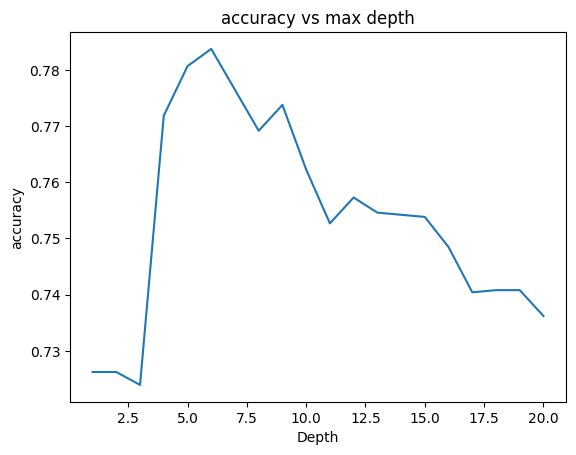

In [78]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
import matplotlib.pyplot as plt

acc = []
depth = [i for i in range(1, 21)]

for d in depth:
    model = DecisionTreeClassifier(random_state = 42, max_depth=d)
    model.fit(X_train, y_train)
    prediction = model.predict(X_val)
    correct_pred = (prediction == y_val).sum()
    total_pred = len(y_val)

    acc.append(correct_pred/total_pred)


plt.plot(depth, acc)
plt.xlabel("Depth")
plt.ylabel("accuracy")
plt.title("accuracy vs max depth")
plt.show()



In [ ]:
model = RandomForestClassifier(random_state=42, max_depth=10)
model.fit(X_train, y_train)

prediction = model.predict(X_val)
correct_pred = (prediction == y_val).sum()
total_pred = len(y_val)

acc = (correct_pred/total_pred)
print("Accuracy:", acc)

In [82]:
from sklearn.ensemble import RandomForestClassifier



# randomforest with gridsearch

model = RandomForestClassifier(random_state=42)


param_grid = {
  'max_depth': [5, 10, 15],
  'n_estimators': [150, 200, 250, 300],  # Number of trees in the forest
  'criterion': ['gini', 'entropy']
}

# Perform Grid Search Cross Validation
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Get the best parameters and the corresponding accuracy
best_params = grid_search.best_params_
best_accuracy = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Accuracy:", best_accuracy)




Accuracy: 0.7967791411042945
Best Parameters: {'criterion': 'entropy', 'max_depth': 10, 'n_estimators': 250}
Best Accuracy: 0.7927691043549713


In [84]:
from sklearn.ensemble import GradientBoostingClassifier


model = GradientBoostingClassifier(max_depth=5, random_state=42)
model.fit(X_train, y_train)

print(model.score(X_val, y_val))

importances = model.feature_importances_

feature_names = train_data_df.columns.tolist()

importance_feature_pairs = zip(importances, feature_names)

# Sort the pairs based on importance values in ascending order
sorted_pairs = sorted(importance_feature_pairs)

# Print the sorted feature importances
for importance, feature_name in sorted_pairs:
    print(f"{feature_name}: importance = {importance}")

0.8075153374233128
PassengerId: importance = 0.042208664076602995
HomePlanet: importance = 0.06272181876718765
CryoSleep: importance = 0.3197813315618484
Cabin: importance = 0.10051885837736814
Destination: importance = 0.0051246224742060795
Age: importance = 0.04085931194262216
VIP: importance = 0.0005361692648532906
RoomService: importance = 0.076983312600635
FoodCourt: importance = 0.08447923727380793
ShoppingMall: importance = 0.045385950673117
Spa: importance = 0.09736715664633651
VRDeck: importance = 0.0928491430586872
Name: importance = 0.031184423282727858



VIP: importance = 0.0005361692648532906
Destination: importance = 0.0051246224742060795
Name: importance = 0.031184423282727858
Age: importance = 0.04085931194262216
PassengerId: importance = 0.042208664076602995
ShoppingMall: importance = 0.045385950673117
HomePlanet: importance = 0.06272181876718765
RoomService: importance = 0.076983312600635
FoodCourt: importance = 0.08447923727380793
VRDeck: importance = 0.092849143058